# The HFM library - A fast marching solver with adaptive stencils 

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Sensitivity analysis

The present notebook is devoted to forward and reverse differentiation of the fast marching algorithm. We limit ourselves to isotropic fast marching, but more complex models are supported equally well, see the subsequent notebooks as well as the publication :

* Jean-Marie Mirebeau and Johann Dreo, “Automatic differentiation of non-holonomic fast marching for computing most threatening trajectories under sensors surveillance,” Geometrical Science of Information conference, 2017. [link](https://hal.archives-ouvertes.fr/hal-01503607)

In [1]:
import sys; sys.path.append("..") # Allow imports from parent directory

In [2]:
from Miscellaneous import TocTools; TocTools.displayTOC('Sensitivity','FMM')

[**Summary**](Summary.ipynb) of this series of notebooks. 

[**Main summary**](../Summary.ipynb), including the other volumes of this work. 


# Table of contents

  * [1. Setting up the problem](#1.-Setting-up-the-problem)
  * [2. Forward differentiation](#2.-Forward-differentiation)
  * [3. Backward differentiation](#3.-Backward-differentiation)
  * [4. An optimization problem : finding the cost function which maximizes distance](#4.-An-optimization-problem-:-finding-the-cost-function-which-maximizes-distance)
  * [5. Sensitivity to several parameters](#5.-Sensitivity-to-several-parameters)
  * [6. Sensitivity at multiple points, possibly weighted](#6.-Sensitivity-at-multiple-points,-possibly-weighted)




This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Importing the required libraries

In [3]:
import HFMUtils

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize

In [5]:
figSaveDir = None #'Figures/Sensitivity/'

At this point, we need to mention that there exists two consistent discretizations of the eikonal equation, namely:
$$
    \|\nabla u(x)\|^2 
    \approx h^{-2} \sum_{1\leq i \leq d} \max \{0,u(x)-u(x-h e_i), u(x)-u(x+h e_i)\}^2, 
$$
and 
$$
    \|\nabla u(x)\|^2 
    \approx h^{-2} \sum_{1\leq i \leq d} \sum_{s \in \{-1,1\}} \max \{0,u(x)-u(x- h s e_i)\}^2,
$$
where $h$ denotes the gridscale, and $(e_1,\cdots,e_d)$ is the canonical basis of $\mathbb R^d$.

* The first implementation (left), referred to as 'Isotropic2', is usually preferred since it is more accurate at points were the solution $u$ looses differentiability, e.g. near the cut locus (the points reached by two minimal geodesics). 

* The second implementation, referred to as 'IsotropicDiff2', has the advantage of being continuously differentiable w.r.t. the values of $u$, and is thus better behaved when it comes to automatic differentiation.

In [9]:
hfmInput = {}
hfmInput['model']='IsotropicDiff2' # Alternatively 'IsotropicDiff2'

## 1. Setting up the problem

We choose as a start to set up a same problem as considered in the [first notebook](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A1_Isotropic.ipynb): a path planning problem involving an isotropic cost, on a two dimensional domain with obstacles.
More precisely, we compute the unique viscosity solution $u: \overline \Omega \to ]-\infty,\infty]$ to an eikonal equation
\begin{align*}
\forall x \in \Omega, \|\nabla u(x)\| &= c(x), &
\forall x \in \partial \Omega, u(x) &= \sigma(x).
\end{align*}
This PDE solution is known to solve the following optimal control problem
\begin{equation*}
    u(x) = \min_{\substack{\gamma(0) \in \partial \Omega\\ \gamma(1)=x}} \sigma(\gamma(0))+ \int_0^1 c(\gamma(t)), \|\gamma'(t)\| \,\mathrm dt
\end{equation*}
and the minimal paths $\gamma:[0,1] \to \overline \Omega$ can be efficiently backtracked.

In [10]:
hfmInput['arrayOrdering']='YXZ_RowMajor'

# Define the domain
hfmInput.update(
    HFMUtils.Rect(sides=[[-1,1],[0,1]],gridScale=1./100.)
)

# Set up the boundary conditions
hfmInput['seeds']=[[-0.5,0.3],[0.5,0.8]] # Seed position
hfmInput['seedValues']=[0.,0.5] # Boundary condition imposed at the seed. Defaults to $[0.,0.]$.

# Define the speed function
X,Y = HFMUtils.GetGrid(hfmInput) # Create a coordinate system
hfmInput['cost'] = np.exp(-0.5*(X**2+Y**2)) # Define the cost function

# Insert the obstacles
disk = (X-0.3)**2 + (Y-0.3)**2 <= 0.2**2
barrier = np.logical_and(X==X[0,70], Y>=0.4)
hfmInput['walls']= np.logical_or(disk,barrier) 

# Request the desired outputs
hfmInput['exportValues']=1. # Ask for the PDE solution
hfmInput['tips'] = [[0.,0.6],[-0.9,0.5],[0.8,0.8]] # Ask for the geodesics from these three points

However, for the purposes of sensitivity analysis, we do avoid two features considered in the first notebook :
* Second order enhancement of the numerical scheme. (Obtained by setting hfmInput['order']=2)
* Time dependent speed functions.

Indeed, if they were used, in the current implementation, then minor inaccuracies could arise in the the computed sensitivities.

Before turning to sensitivity analysis, let us recall how the software is run and its output displayed.

In [11]:
hfmOutput = HFMUtils.Run(hfmInput)

Returned with exit code  127



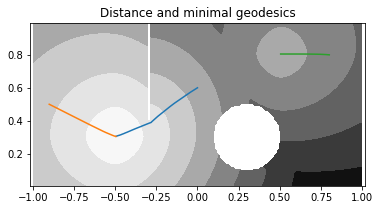

In [9]:
plt.figure(figsize=[6,3]); plt.title('Distance and minimal geodesics'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(hfmOutput): plt.plot(geo[:,0],geo[:,1]) 
plt.contourf(X,Y,hfmOutput['values'],cmap='Greys');

## 2. Forward differentiation



In this section, we differentiate the front arrival times $u : \Omega \to ]-\infty,\infty[$ w.r.t variations in the cost function $c : \Omega \to ]0,\infty[$, and in the boundary conditions $\sigma : \Omega\to ]-\infty,\infty[$.
More precisely, denote by $u[c,\sigma] : \Omega \to ]-\infty,\infty[$, the solution to the eikonal equation
\begin{align*}
    \forall x \in \Omega, \| \nabla u[c,\sigma](x) \| &= c(x) &
    \forall x \in \partial \Omega, u[c,\sigma](x) &= \sigma(x).
\end{align*}

Consider perturbation fields $\xi : \Omega \to \mathbb R$ and $\zeta : \partial \Omega \to \mathbb R$. Forward differentiation allows to compute the first term  $\nu : \Omega \to \mathbb R$ in the Taylor expansion of the distance function, if it exists. In other words
\begin{equation*}
\mu(x) := \frac d {d \varepsilon} u[c+ \varepsilon \xi, \sigma+ \varepsilon \zeta] (x)
\end{equation*}

In [93]:
cost = hfmInput['cost'];

# Define the cost perturbation(s), above named xi. We actually define three perturbations, 
# xi_0 (on the right side of the domain only), xi_1 (on the left side only), and xi_2 (no perturbation)
hfmInput['costVariation']= np.stack([(X>0.)*cost, (X<=0.)*cost, 0.*X],2) 

# Define the boundary condition perturbation(s), above named zeta. 
# Again, similarly define three perturbation, zeta_0 (no perturbation), zeta_1 (no perturbation), and zeta_2.
hfmInput['seedValueVariation']=np.stack([[0,0],[0,0],hfmInput['seedValues']],1) 

In [94]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.00461 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


The following cell shows the effect $\mu_0$ of the first perturbation $(\xi_0,\zeta_0)$. Since $\xi_0$ is positive in the right side of the domain $\{x>0\}$, the perturbation increases the cost function there, hence also the value function. Therefore $\mu_0>0$ where $\{x>0\}$, as can be observed numerically. On the other hand $\zeta_0=0$, which means that boundary conditions, in other words the seed values, are untouched.

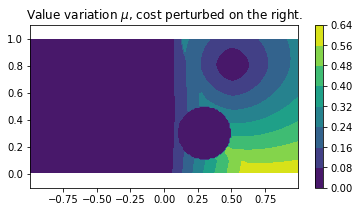

In [95]:
plt.figure(figsize=[6,3]); plt.title(r'Value variation $\mu$, cost perturbed on the right.'); plt.axis('equal'); 
# The field 'valueVariation' is denoted mu in the above mathematical expression.
plt.contourf(X,Y,hfmOutput['valueVariation'][:,:,0]) 
plt.axis('equal');plt.colorbar();

The following cell shows the effect $\mu_1$ of the second perturbation $(\xi_1,\zeta_1)$. Since $\xi_1$ is positive on the left side of the domain $\{x\leq 0\}$, the perturbation increases the cost function there, hence also the value function $u$. Therefore $\mu_1>0$ where $\{x \leq 0\}$, as can be observed numerically.

However, one can note that $\mu_1>0$ on part of the right side of the domain $\{x>0\}$ as well. That is because the corresponding minimal paths come from the left part of the domain, hence they see their cost increased by the perturbation.

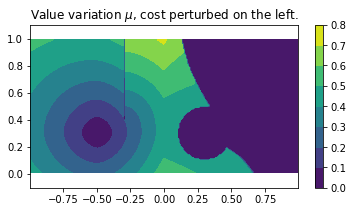

In [96]:
fig = plt.figure(figsize=[6,3]); plt.title(r'Value variation $\mu$, cost perturbed on the left.'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['valueVariation'][:,:,1])
plt.axis('equal');plt.colorbar();

In [97]:
if figSaveDir: fig.savefig(figSaveDir+'ValueVariation_CostPerturbationLeft.png')

The third perturbation affects the boundary conditions only: $\xi_2=0$ and $\zeta_2 \neq 0$. More precisely, the perturbation increases the boundary condition at the right seed $x_1$ only. Therefore, as can be observed numerically, hence the value function $u$ increases in the Voronoi region of $x_1$ only. In other words $\mu_2>0$ at at all the points for which the backtracked geodesic leads to $x_1$.

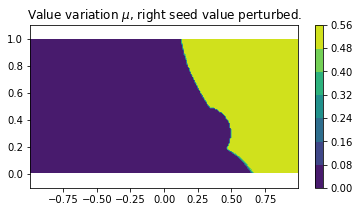

In [98]:
fig = plt.figure(figsize=[6,3]); plt.title(r'Value variation $\mu$, right seed value perturbed.'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['valueVariation'][:,:,2])
plt.axis('equal');plt.colorbar();

In [99]:
if figSaveDir: fig.savefig(figSaveDir+'ValueVariation_SeedValuePerturbationRight.png')

We end this section with a consistency test, based on a mathematical property that we describe below.

It is worth noting that the arrival time function $u$ is $1$-homogeneous w.r.t. its parameters $c$ and $\sigma$
\begin{equation*}
u[\lambda c,\lambda \sigma] = \lambda u[c,\sigma].
\end{equation*}
This implies a differential identity, referred to as Euler identity for homogeneous functions:
\begin{equation*} 
    \frac d {d\lambda} u[\lambda c,\lambda \sigma] = u[c,\sigma].
\end{equation*}
In the test case above, we have chosen the perturbations such that $\xi_0+\xi_1+\xi_2 = c$ and $\zeta_0+\zeta_1+\zeta_2 = \sigma$. Thus denoting by $\mu_0,\mu_1,\mu_2$ the corresponding value variations, Euler's identity implies that $\mu_0+\mu_1+\mu_2 = u$, as can be observed numerically.

In [100]:
values = hfmOutput['values']; 
values[hfmInput['walls']]=0.; # Eliminate values inside walls, which equal Infinity
np.max(np.abs(hfmOutput['valueVariation'][:,:,0]+hfmOutput['valueVariation'][:,:,1]
              +hfmOutput['valueVariation'][:,:,2]-values)) # Check Euler's identity

1.3322676295501878e-15

## 3. Backward differentiation

Consider a cost function $c : \Omega \to ]0,\infty[$ and some boundary values $\sigma : \Omega \to ]-\infty,\infty]$. Backward differentiation, for a given point $x\in \Omega$ provides two fields $\rho = \rho[x,c,\sigma] : \Omega \to \mathbb R$ and $\pi = \pi[x,c,\sigma] : \partial \Omega \to \mathbb R$ such that 
\begin{equation*}
u[c+\varepsilon \xi,\sigma+\varepsilon \zeta](x) = u[x,\sigma](x)+ \varepsilon \Bigg(\int_\Omega \rho \xi + \int_{\partial \Omega} \pi \zeta\Bigg) + o(\varepsilon).
\end{equation*}
This equality holds, assuming differentiability, for any perturbation $\xi$ of the cost function $c$, and any perturbation $\zeta$ of the boundary condition $\sigma$.
The fields $\rho$ and $\pi$ express how much the front arrival time value $u[c,\sigma]$ is sensitive to variations in these parameters.


In [101]:
hfmInput['inspectSensitivity']=[ [-0.8,0.8], [0.575,0.1] ] # Ask for rho and pi related to these two points

In [102]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004942 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


As can illustrated in the next cell, the sensitivity $\rho = \rho[x,c,\sigma]$, of the value function $u(x)$ at a given point $x$ w.r.t. variations in the cost $c$, is (mostly) supported in the neighborhood of the minimal geodesic from $x$ to the nearest seed point. This property is actually at the foundation of one of our backtracking methods.

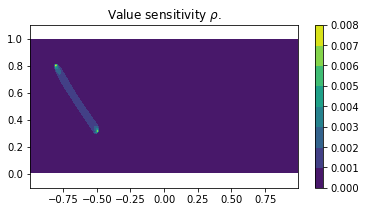

In [103]:
plt.figure(figsize=[6,3]); plt.title(r'Value sensitivity $\rho$.'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['costSensitivity_0']); # rho
plt.colorbar();

The second point $x_2 = (0.575,0.1)$ for which we request the sensitivity, is located precisely on the cut locus. In other words, it is at equal distance of the two seeds (taking into account the boundary conditions). The corresponding sensitivity $\rho$ is thus supported on the neighborhood of two geodesics.

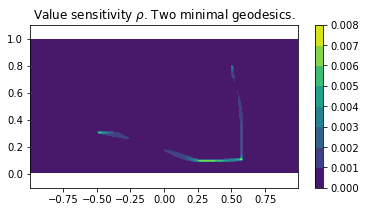

In [104]:
fig = plt.figure(figsize=[6,3]); plt.title(r'Value sensitivity $\rho$. Two minimal geodesics.'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['costSensitivity_1']);
plt.axis('equal');plt.colorbar();

In [105]:
if figSaveDir: fig.savefig(figSaveDir+'ValueSensitivity_TwoPaths.png')

The sensitivity of the value $u[x,c,\sigma]$ w.r.t. the boundary condition $\sigma$ is also returned, above denoted $\pi : \partial \Omega \to \mathbb R$. The format is 
\begin{equation*}
[ [s_0^0,s_0^1,\pi_0], [s_1^0,s_1^1,\pi_1], ...].
\end{equation*}
Here $s_0=(s_0^0,s_0^1)$ and $s_1=(s_1^0,s_1^1)$ are the seeds for which the corresponding sensitivity $\pi_0$ and $\pi_1$ is positive. 
If the sensitivity $u(x)$ was requested unless for a generic point $x$, then the list is of length one, and of the form $[ [s^0,s^1,1] ]$. In addition $s=(s^0,s^1)$ is the seed linked to $x$ by the minimal path.

In [106]:
hfmOutput['seedSensitivity_0']

array([[-0.495,  0.305,  1.   ]])

However, if sensitivity is requested for a point on the cut-locus, for which there exists several minimal geodesics leading to distinct seeds, then $\pi$ is supported on several seeds.

In [107]:
hfmOutput['seedSensitivity_1']

array([[ 0.505     ,  0.805     ,  0.37180042],
       [-0.495     ,  0.305     ,  0.62819958]])

A slight annoyance of the above output is that the original seeds are not returned. Instead, the returned positions correspond to the nearest point on the discretization grid. Some minor postprocessing, for instance by converting these points to multi-indices, is thus required to establish the matching.

In [108]:
hfmInput['pointToIndex'] = np.concatenate((hfmInput['seeds'],hfmOutput['seedSensitivity_1'][:,0:2]))
hfmOutput = HFMUtils.Run(hfmInput)
print("Seeds, original and nearest gridpoint :\n", hfmInput['pointToIndex'],"\n")
print("Indices :\n", hfmOutput['indexFromPoint'].astype(int))
# Note that the order of the seeds may not be preserved

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.00484 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Seeds, original and nearest gridpoint :
 [[-0.5    0.3  ]
 [ 0.5    0.8  ]
 [ 0.505  0.805]
 [-0.495  0.305]] 

Indices :
 [[ 50  30]
 [150  80]
 [150  80]
 [ 50  30]]


We conclude this section with a consistency check. More precisely, we ensure that our two automatic differentiation methods yield consistent results.
Both can be used to compute the scalar $\mu(x)$ appearing in the following Taylor expansion
\begin{equation*}
    u[c+\varepsilon \xi, \sigma+\varepsilon \zeta] (x) = u[c,\sigma](x)+\varepsilon \mu(x) + o(\varepsilon),
\end{equation*}
where the point $x$ and the perturbations $\xi$ and $\zeta$ are given.
The two differentiation methods use distinct inputs, as follows.
* Forward differentiation. *Input*: $\xi$ (costVariation), $\zeta$ (seedValueVariation). *Output*: $\mu$ (valueVariation).
* Backward differentiation. *Input*: $x$ (inspectSensitivity). *Output*: $\rho$ (costSensitivity) and $\pi$ (seedSensitivity).

The inputs $x,\zeta,\xi$ and outputs $\mu, \rho, \pi$, are mathematically tied by the the following identity, which we verify numerically:
\begin{equation*}
\mu(x) = \int_\Omega \rho \xi + \int_{\partial \Omega} \pi \zeta.
\end{equation*}

In [109]:
# Get the grid indices index0 and index1, of the points x0 and x1 at which sensitivity was computed
hfmInput['pointToIndex'] = hfmInput['inspectSensitivity'] 
hfmOutput = HFMUtils.Run(hfmInput)
index0, index1 = hfmOutput['indexFromPoint'].astype(int)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004586 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


In the first instance of forward differentiation, boundary conditions were not perturbed ($\zeta=0$). Hence we expect, and numerically check, that $\mu(x) = \int_\Omega \rho \xi$.

In [110]:
hfmOutput['valueVariation'][index1[1],index1[0],0] # Evaluates mu(x)

0.5496012443997507

In [111]:
(hfmInput['costVariation'][:,:,0]*hfmOutput['costSensitivity_1']).sum() #  Evaluates int_Omega rho*xi 

0.5496012443997509

In the last instance of forward differentiation, the cost function was not perturbed ($\xi=0$). Hence we expect, and numerically check, that  $\mu(x) = \int_{\partial\Omega} \pi \zeta$.

In [112]:
hfmOutput['valueVariation'][index1[1],index1[0],2] # Evaluates mu(x)

0.18590020885259528

In [113]:
np.dot(hfmOutput['seedSensitivity_1'][(1,0),2] , hfmInput['seedValueVariation'][:,2]) # int_Boundary pi*zeta

0.18590020885259562

## 4. An optimization problem : finding the cost function which maximizes distance

We illustrate automatic differentiation solving an optimization problem posed on cost functions $c$. The objective is to maximize the distance from a point $x_*$ to the boundary, minus a integral penalty on the cost. Formally, the problem reads as follows
\begin{align*}
    \max_{c : \Omega \to [\alpha,\beta]} \, u[c](x_*) - \gamma \int_\Omega c.
\end{align*}
The bounds $\alpha,\beta > 0$ imposed on the cost function, and the penalization factor $\gamma >0$ on the cost function integral, are given parameters, as well as the target point $x_*$.

Experiments of similar nature are presented in :
* F. Benmansour, G. Carlier, G. Peyré, and F. Santambrogio, “Derivatives with respect to metrics and applications: subgradient marching algorithm,” Numerische Mathematik, vol. 116, no. 3, pp. 357–381, May 2010.
* J.-M. Mirebeau and J. Dreo, “Automatic differentiation of non-holonomic fast marching for computing most threatening trajectories under sensors surveillance,” presented at the Geometrical Science of Information, 2017.

In [114]:
optInput = {}
optInput['model']='IsotropicDiff2' # Alternatively, 'Isotropic2'

In [115]:
#Fast marching parameters, copied from earlier problem, with different seed
for key in ['arrayOrdering','dims','gridScale','origin','walls']:
    optInput[key]=hfmInput[key]

# Problem parameters
alpha = 0.1; beta=1.; gamma=1.5;
optInput['seeds']=[[-0.7,0.7]] # Seed position

# For better stability, we slightly spread the target x_* on the four neighbor points
targetIndices = [[180,40],[179,40],[181,40],[180,39],[180,41]]; 
targetWeights = [0.5,0.125,0.125,0.125,0.125]
#Unspread target, commented below, yields less stable computations.
#targetIndices = [[180,40]]; targetWeights = [1]; 

# Silent the execution, since HFM will be called many times
optInput['verbosity']=0

optInput['cost']=1; optInput['indexToPoint']=targetIndices;
targetPoints = HFMUtils.Run(optInput)['pointFromIndex']

# Utilities
allOnes = np.ones(optInput['dims'].astype(int).prod())
YXZ_Shape = optInput['dims'][[1,0]].astype(int)

We prepare two functions returning the objective function and its jacobian. 

This particular test application works better with the differentiable scheme 'IsotropicDiff2', although the usual discretization 'Isotropic2' is still usable.

In [116]:
def func(cost,sign=1):
    optInput['cost']=cost.reshape(YXZ_Shape)
    optInput['exportValues']=1
    optInput.pop('inspectSensitivity',None)
    optOutput = HFMUtils.Run(optInput)
    value = sum([weight*optOutput['values'][index[1],index[0]] for index,weight in zip(targetIndices,targetWeights)])
    return sign*(value - gamma*cost.sum()*optInput['gridScale']**2)

def func_deriv(cost,sign=1):
    optInput['cost']=cost.reshape(YXZ_Shape)
    optInput['exportValues']=0
    
    # Request sensitivity for a weighted sum of values
    optInput['inspectSensitivity'] = targetPoints 
    optInput['inspectSensitivityWeights'] = targetWeights
    optInput['inspectSensitivityLengths'] = [len(targetWeights)]
    
    optOutput = HFMUtils.Run(optInput)
    return sign*(optOutput['costSensitivity_0'].flatten() - gamma*allOnes*optInput['gridScale']**2)

In [117]:
# Warning : takes up to a minute.
import time; start_time = time.time()

res = scipy.optimize.\
minimize(func,
         allOnes*(alpha+beta)/2., # Initial guess
         bounds=np.array((alpha*allOnes,beta*allOnes)).transpose(), # alpha <= c <= beta
         jac=func_deriv,
         args=(-1.), # Minimize instead of maximize
         method='L-BFGS-B',options={'gtol':1e-4,'maxiter':300})

print("--- %s seconds ---" % (time.time() - start_time))

--- 5.739131927490234 seconds ---


The optimal strategy uses a large cost around the seed, the target, around the boundary of obstacles, ...

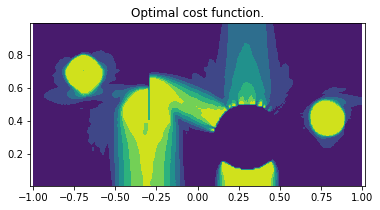

In [118]:
fig = plt.figure(figsize=[6,3]); plt.title('Optimal cost function.'); plt.axis('equal'); 
plt.contourf(X,Y,res.x.reshape(YXZ_Shape));

In [119]:
if figSaveDir: fig.savefig(figSaveDir+'OptimalCost.png')

At the optimal strategy, there is a continuum of optimal curves, spread all over the domain.

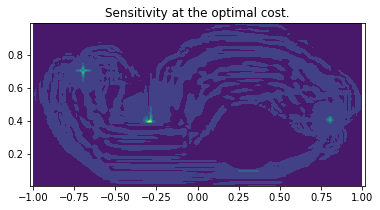

In [120]:
fig = plt.figure(figsize=[6,3]); plt.title('Sensitivity at the optimal cost.'); plt.axis('equal'); 
plt.contourf(X,Y,func_deriv(res.x).reshape(YXZ_Shape));

In [121]:
if figSaveDir: fig.savefig(figSaveDir+'OptimalSensitivity.png')

In [122]:
optInput['tips']=optInput['inspectSensitivity']
optInput['exportValues']=1
optOutput = HFMUtils.Run(optInput)

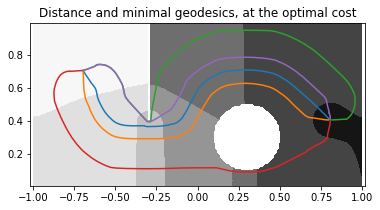

In [123]:
fig = plt.figure(figsize=[6,3]); plt.title('Distance and minimal geodesics, at the optimal cost'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(optOutput): plt.plot(geo[:,0],geo[:,1]) 
plt.contourf(X,Y,optOutput['values'],cmap='Greys');

In [124]:
if figSaveDir: fig.savefig(figSaveDir+'OptimalPathCost.png')

## 5. Sensitivity to several parameters

In this experiment, we consider a metric depending on two cost functions, and perform sensitivity analysis w.r.t. each both. More precisely, we use the two dimensional diagonal metric model, which lets the user choose different costs of motion along the $x$ and $y$ axes.

This model admits a differentiable variant, similarly to the isotropic case, although it is not implemented at the time of writing.

In [125]:
hfmInput2={}
hfmInput2['model']='Diagonal2'

In [126]:
# Possibly distinct cost, and scale, in the x and y directions
cost = hfmInput['cost']; gridScale= hfmInput['gridScale'];
hfmInput2['cost'] = np.stack((cost, cost),axis=2)
hfmInput2['gridScales'] = [gridScale, gridScale]

for key in ['walls','dims','seeds','tips','seedValues','arrayOrdering','exportValues','origin','inspectSensitivity']:
    hfmInput2[key]=hfmInput[key]

In [127]:
hfmOutput = HFMUtils.Run(hfmInput) # Isotropic model
print("---")
hfmOutput2 = HFMUtils.Run(hfmInput2) # Diagonal model

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004661 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004523 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


In order to make a consistency check, the diagonal matrix was set up to reproduce exactly the isotropic cost, by choosing identical diagonal coefficients.

In [128]:
# Arrival time values are equal by construction of the test cases
walls,values,values2 = hfmInput['walls'],hfmOutput['values'].copy(),hfmOutput2['values'].copy()
values[walls]=0; values2[walls]=0; # Values equal inf on the walls.
np.max(np.abs(values-values2))

0.0

We first discuss backward differentiation. As can be observed, the sensitivity of the arrival time w.r.t. variations of the cost associated with the x and y directions are now returned separately.

In [129]:
sensitivity2 = hfmOutput2['costSensitivity_0'] # Sensitivity of the arrival time at the first point

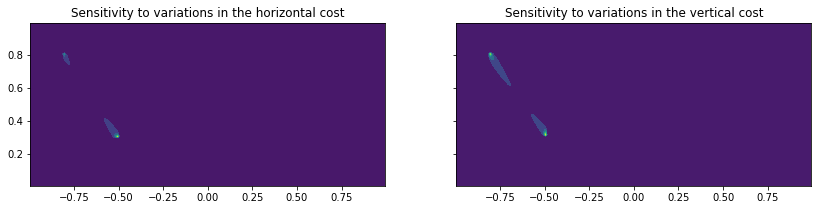

In [130]:
_, (ax0,ax1) = plt.subplots(1,2,sharey=True,figsize=(14,3));

# Display sensitivity w.r.t variations of the first component of the cost, relative to the x direction
ax0.set_title('Sensitivity to variations in the horizontal cost')
ax0.contourf(X,Y,sensitivity2[:,:,0]) 
ax1.set_title('Sensitivity to variations in the vertical cost')
ax1.contourf(X,Y,sensitivity2[:,:,1]);

Consistency check with the isotropic case. Since we choose a diagonal model with equal costs along the two axes, we fall back to the sensitivity of the isotropic model by adding the two sensitivities of the diagonal model.

In [131]:
np.max(np.abs(sensitivity2.sum(axis=2)-hfmOutput['costSensitivity_0']))

8.673617379884035e-19

We next turn to forward differentiation. We may specify distinct variations for the two components of the cost, here associated with the and X,Y axes. 

In [132]:
hfmInput2['costVariation'] = np.stack([ np.stack( (X+Y**2, cost,    0.*cost), axis=2),  
                                        np.stack( (Y-X,    0.*cost, cost),    axis=2)] ,3)
hfmInput2['seedValueVariation']=np.stack([[0,0],[0,0],hfmInput['seedValues']],1) # Above named zeta.

In [133]:
hfmOutput2 = HFMUtils.Run(hfmInput2) 

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004655 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.0001
Field geodesicVolumeBound defaults to 4.225
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


In [134]:
hfmInput2['costVariation'][:,:,0,:].shape

(100, 200, 2)

Consistency check with sensitivity analyis.

In [135]:
(hfmInput2['costVariation'][:,:,0,:]*hfmOutput2['costSensitivity_1']).sum()  \
    - hfmOutput2['valueVariation'][index1[1],index1[0],0] 

-1.3877787807814457e-17

Consistency check based on Euler's identity for homogeneous functions.

In [136]:
np.max(np.abs(hfmOutput2['valueVariation'][:,:,1]+hfmOutput2['valueVariation'][:,:,2]-values))

1.3322676295501878e-15

## 6. Sensitivity at multiple points, possibly weighted

The HFM library lets you compute the sensitivity at multiple points, possibly weighted. 
For instance, assume $u : \Omega \to R$ is a distance map computed using the fast marching algorithm. 
Let also $x_0,x_1,x_2 \in \Omega$ and $\alpha_0,\alpha_1,\alpha_2 \in R$. We show how to compute the sensitivity of the the vector
$$
    (\alpha_0 u(x_0)+\alpha_1 u(x_1),\ \alpha_2 u(x_2))
$$
w.r.t. variations of the cost function.

In [137]:
# Define the problem
hfmIn = {
    'model':'Isotropic2',
    'cost':1.,
    'seeds':[[0.,0.]],
    'exportValues':1.,
    'arrayOrdering':'RowMajor'
}
hfmIn.update(HFMUtils.Rect(sides=[[-1.,1.],[-1.,1.]],dimx=100))
X = np.array(HFMUtils.GetGrid(hfmIn))

In [138]:
# Where to get the sensitivity
x0,x1,x2 = [0.1,-0.4],[0.5,0.8],[-0.5,-0.7] 
alpha0,alpha1,alpha2 = 2.,3.,4.5 

# Format this data for the input
hfmIn['inspectSensitivity'] = [x0,x1,x2] 
hfmIn['inspectSensitivityWeights'] = [alpha0,alpha1,alpha2]

# How to group the points (here the first two are summed together, and the last one is alone)
hfmIn['inspectSensitivityLengths'] = [2.,1.]

In [139]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.002318 s.
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


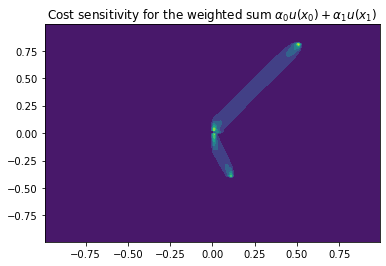

In [140]:
plt.title(r"Cost sensitivity for the weighted sum $\alpha_0 u(x_0)+\alpha_1 u(x_1)$")
plt.contourf(X[0],X[1],hfmOut['costSensitivity_0']);

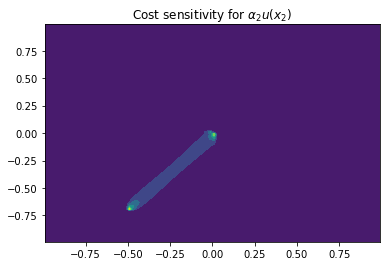

In [141]:
plt.title(r"Cost sensitivity for $\alpha_2 u(x_2)$")
plt.contourf(X[0],X[1],hfmOut['costSensitivity_1']);